In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, linprog
from textwrap import dedent
%matplotlib inline

np.set_printoptions(precision=2)

In [2]:
class Neumann(object):

    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) and Gale (1960, Chapter 9.5):

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with non-negative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with non-negative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have non-negative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices \
              must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and \
              output matrices must have only non-negative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well-formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate)
        and beta (interest factor). See the proof of Theorem 9.8 in Gale (1960)
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # Upper bound for α, β
        LB = fsolve(g, 2).item()  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a
        two-player zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0:
            print(res.message)

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given γ (= α or β), the matrix "M = B - γ * A"
        defines a two-player zero-sum game, where the optimal strategies are
        the (normalized) intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given gamma (= alpha or beta),
        the matrix "M = B - γ * A" defines a two-player zero-sum game,
        where the optimal strategies are the (normalized) intensity and price
        vector

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

In [3]:
# (1) Irreducible (A, B) example: α_0 = β_0
A1 = np.array([[0, 1, 0, 0],
               [1, 0, 0, 1],
               [0, 0, 1, 0]])

B1 = np.array([[1, 0, 0, 0],
               [0, 0, 2, 0],
               [0, 1, 0, 1]])

# (2) Reducible (A, B) example: β_0 < α_0
A2 = np.array([[0, 1, 0, 0, 0, 0],
               [1, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 1, 0, 0, 1],
               [0, 0, 0, 0, 1, 0]])

B2 = np.array([[1, 0, 0, 1, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 2, 0],
               [0, 0, 0, 1, 0, 1]])

In [4]:
n1 = Neumann(A1, B1)
n1


Generalized von Neumann expanding model:
  - number of goods          : 4
  - number of activities     : 3

Assumptions:
  - AI:  every column of B has a positive entry    : True
  - AII: every row of A has a positive entry       : True


In [5]:
n2 = Neumann(A2, B2)
n2


Generalized von Neumann expanding model:
  - number of goods          : 6
  - number of activities     : 5

Assumptions:
  - AI:  every column of B has a positive entry    : True
  - AII: every row of A has a positive entry       : True


In [6]:
n1.bounds()

(1.0, 2.0)

In [7]:
γ = 2

print(f'Value of the game with γ = {γ}')
print(n1.zerosum(γ=γ)[0])
print('Intensity vector (from the primal)')
print(n1.zerosum(γ=γ)[1])
print('Price vector (from the dual)')
print(n1.zerosum(γ=γ, dual=True)[1])

Value of the game with γ = 2
-0.24
Intensity vector (from the primal)
[0.32 0.28 0.4 ]
Price vector (from the dual)
[0.4  0.32 0.28 0.  ]


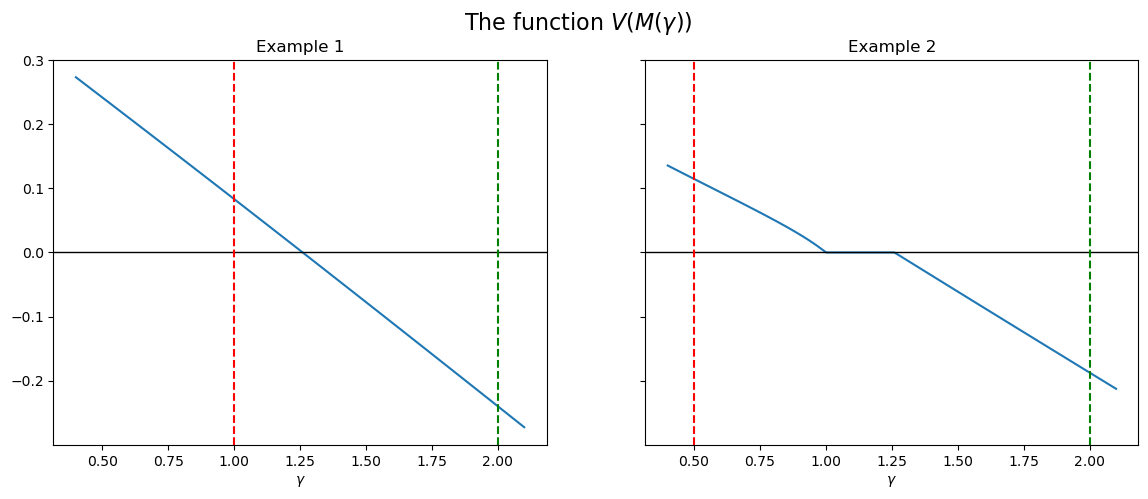

In [8]:
numb_grid = 100
γ_grid = np.linspace(0.4, 2.1, numb_grid)

value_ex1_grid = np.asarray([n1.zerosum(γ=γ_grid[i])[0]
                            for i in range(numb_grid)])
value_ex2_grid = np.asarray([n2.zerosum(γ=γ_grid[i])[0]
                            for i in range(numb_grid)])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle(r'The function $V(M(\gamma))$', fontsize=16)

for ax, grid, N, i in zip(axes, (value_ex1_grid, value_ex2_grid),
                          (n1, n2), (1, 2)):
    ax.plot(γ_grid, grid)
    ax.set(title=f'Example {i}', xlabel='$\gamma$')
    ax.axhline(0, c='k', lw=1)
    ax.axvline(N.bounds()[0], c='r', ls='--', label='lower bound')
    ax.axvline(N.bounds()[1], c='g', ls='--', label='upper bound')

plt.show()

In [9]:
α_0, x, p = n1.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'The corresponding p from the dual = {p}')

α_0 = 1.2599210478365421
x_0 = [0.33 0.26 0.41]
The corresponding p from the dual = [0.41 0.33 0.26 0.  ]


In [10]:
β_0, x, p = n1.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'The corresponding x from the primal = {x}')

β_0 = 1.2599210478365421
p_0 = [0.41 0.33 0.26 0.  ]
The corresponding x from the primal = [0.33 0.26 0.41]


In [11]:
α_0, x, p = n2.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'The corresponding p from the dual = {p}')

α_0 = 1.259921052493155
x_0 = [5.27e-10 0.00e+00 3.27e-01 2.60e-01 4.13e-01]
The corresponding p from the dual = [0.   0.21 0.33 0.26 0.21 0.  ]


In [12]:
β_0, x, p = n2.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'The corresponding x from the primal = {x}')

β_0 = 1.0000000009313226
p_0 = [ 5.00e-01  5.00e-01 -1.55e-09 -1.24e-09 -9.31e-10  0.00e+00]
The corresponding x from the primal = [-0.    0.    0.25  0.25  0.5 ]
